In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,confusion_matrix, classification_report

current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)
root_path = '/content/gdrive/Othercomputers/My Computer/Fire_risk_main/Fire_risk_main/data/Fire-data-paper-hongru_share/'
data_path= root_path + '/github_repo/data/'


In [7]:
df=pd.read_pickle(data_path + '/step2_consequence_loss.pkl')
df_new2=pd.read_pickle(data_path + '/raw_data_with_city_info.pkl')


In [8]:
df.drop(columns=['PROP_LOSS','CONT_LOSS','FIRE_SPRD'],inplace=True)


In [9]:
df.columns

Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'BLDG_ABOVE', 'BLDG_BELOW',
       'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR', 'DET_OPERAT',
       'AES_PRES', 'INCIDENT_KEY', 'AID', 'SUP_APP', 'EMS_APP', 'OTH_APP',
       'SUP_PER', 'EMS_PER', 'OTH_PER', 'response_time',
       'last_unit_clear_time', 'accident_year', 'accident_month',
       'accident_day', 'accident_hour', 'median_income_list',
       'median_rent_list', 'total_population_list',
       'build_time_1939_and_earlier_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_GRAPI_35_pct_or_more_list',
       'Pct_GRAPI_Less_than_15_pct_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Less_than_9th_grade_list', 'Pct_EDU_Bachelor_or_higher_list',
       'Pct_HIC_With_coverage_list', 'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
       'total_loss', 'ARE

In [10]:
cpi_map={'2012':1,
         '2013':1.02,
         '2014':1.02,
         '2015':1.03,
         '2016':1.05,
         '2017':1.07,
         '2018':1.09,
         '2019':1.12,
         '2020':1.13,
         '2021':1.21,
         '2022':1.29
}
df['median_income_list'] = df.apply(lambda row: row['median_income_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)
df['median_rent_list'] = df.apply(lambda row: row['median_rent_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)
df['total_loss'] = df.apply(lambda row: row['total_loss'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)


In [11]:
df=df[df['CAUSE_IGN']!='0']
df=df[df['HEAT_SOURCE_new']!='6']
df=df[df['FACT_IGN1_new']!='7']
df=df[df['AREA_ORIG_new']!='8']
df=df[df['AREA_ORIG_new']!='9']

def remove_outliers_z(df, columns, threshold=3):
    for col in columns:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df = df[(z_scores < threshold) & (z_scores > -threshold)]
    return df
df = remove_outliers_z(df, ['total_loss'])

df = df[(df['last_unit_clear_time'] < 600)&(df['TOT_SQ_FT'] < 50000)].reset_index().drop(columns = ['index'])


In [12]:
df.shape

(484964, 60)

In [13]:
# Assuming df is your DataFrame
object_columns = df.select_dtypes(include=['object']).columns
float_columns = df.select_dtypes(include=['float']).columns


print("Object columns:", object_columns)
print("Float columns:", float_columns)


Object columns: Index(['STATE', 'CAUSE_IGN', 'FLAME_SPRD', 'DETECTOR', 'DET_OPERAT',
       'AES_PRES', 'INCIDENT_KEY', 'AID', 'accident_year', 'accident_month',
       'accident_day', 'accident_hour', 'hum_1', 'AREA_ORIG_new',
       'ACT_TAK1_new', 'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new',
       'TYPE_MAT_new', 'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new',
       'MAT_SPRD_new'],
      dtype='object')
Float columns: Index(['NUM_UNIT', 'BLDG_ABOVE', 'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG',
       'SUP_APP', 'EMS_APP', 'OTH_APP', 'SUP_PER', 'EMS_PER', 'OTH_PER',
       'response_time', 'last_unit_clear_time', 'median_income_list',
       'median_rent_list', 'total_population_list',
       'build_time_1939_and_earlier_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_GRAPI_35_pct_or_more_list',
       'Pct_GRAPI_Less_than_15_pct_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Less_than_9th_grade_list', 'Pct_EDU_Bachelor_or_higher_list',


In [14]:
columns_drop=['DET_OPERAT','build_time_1939_and_earlier_list','build_time_1940_to_1979_list','total_population_list','SUP_APP', 'EMS_APP', 'OTH_APP','Pct_GRAPI_35_pct_or_more_list',
       'Pct_GRAPI_Less_than_15_pct_list','Pct_EDU_Less_than_9th_grade_list',
       'SUP_PER', 'EMS_PER', 'OTH_PER','AID']
df.drop(columns=columns_drop,inplace=True)

In [15]:
df.columns, df.shape

(Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'BLDG_ABOVE', 'BLDG_BELOW',
        'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
        'INCIDENT_KEY', 'response_time', 'last_unit_clear_time',
        'accident_year', 'accident_month', 'accident_day', 'accident_hour',
        'median_income_list', 'median_rent_list', 'Pct_HOU_Occupied_units_list',
        'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
        'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
        'Pct_SA_62_and_over_list',
        'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
        'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
        'total_loss', 'AREA_ORIG_new', 'ACT_TAK1_new', 'FACT_IGN1_new',
        'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new', 'PROP_USE_new',
        'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new',
        'build_time_1980_to_later_list', 'solar_or_no_fuel', 'coal_or_wood'],
       dtyp

In [16]:
df.shape

(484964, 46)

In [17]:
df_new=df_new2[['INCIDENT_KEY', 'CBSA Code','CBSA Title','State_Abbrs', 'HHS_Region',
       'Census_Region', 'Census_Division']]
df_filtered=df.merge(df_new,on='INCIDENT_KEY',how='left').copy()

counts = df_filtered.groupby(['CBSA Title']).size().reset_index(name='count')

# Keep only those with count >= 2
valid_pairs = counts[counts['count'] >= 5][['CBSA Title','count']]

# Merge to filter the DataFrame
df_filtered = df_filtered.merge(valid_pairs, on=['CBSA Title'])
df_filtered.drop(columns=['count'],inplace=True)

In [18]:
df_filtered.columns, df_filtered.shape

(Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'BLDG_ABOVE', 'BLDG_BELOW',
        'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
        'INCIDENT_KEY', 'response_time', 'last_unit_clear_time',
        'accident_year', 'accident_month', 'accident_day', 'accident_hour',
        'median_income_list', 'median_rent_list', 'Pct_HOU_Occupied_units_list',
        'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
        'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
        'Pct_SA_62_and_over_list',
        'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
        'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
        'total_loss', 'AREA_ORIG_new', 'ACT_TAK1_new', 'FACT_IGN1_new',
        'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new', 'PROP_USE_new',
        'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new',
        'build_time_1980_to_later_list', 'solar_or_no_fuel', 'coal_or_wood',
        'CBS

In [19]:

df_label = df_filtered.copy()

# Assuming df is your DataFrame and 'total_loss' is the column with labels
# Create the directory if it doesn't exist

thresholds = df_label['total_loss'].quantile([0.5, 0.75, 0.9])
thresholds = df_label['total_loss'].quantile([0.4, 0.75])

print(thresholds)
#bins = [-float('inf'), thresholds[0.5], thresholds[0.75], thresholds[0.9], float('inf')]
bins = [-float('inf'), thresholds[0.4], thresholds[0.75], float('inf')]

#labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
labels = ['0', '1', '2']

df_label['Risk_Group'] = pd.cut(df_label['total_loss'], bins=bins, labels=labels, include_lowest=True)


X = df_label.drop(columns=['total_loss','Risk_Group','last_unit_clear_time','CBSA Title', 'State_Abbrs', 'HHS_Region',
        'Census_Region', 'Census_Division'])
#X = df.drop(columns=['total_loss','Risk_Group'])
y = df_label['Risk_Group']

X_train_list, X_test_list = [], []
y_train_list, y_test_list = [],[]

# Loop over each region
for region_name, group_df in X.groupby('CBSA Code'):
    y_group = y[group_df.index]  # align y with current group

    # Stratify on y within the group
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(
        group_df, y_group, test_size=0.3, random_state=2042
    )

    # Collect the splits
    X_train_list.append(X_train_group)
    X_test_list.append(X_test_group)
    y_train_list.append(y_train_group)
    y_test_list.append(y_test_group)

# Concatenate all regions
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

X_train.drop(columns=['CBSA Code'], inplace=True)
X_test.drop(columns=['CBSA Code'], inplace=True)


categorical_features = [col for col in X_test.columns if X_test[col].dtype == 'object']


train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)

0.40    10117.647059
0.75    66308.411215
Name: total_loss, dtype: float64


In [20]:
y.value_counts(normalize=True)

,proportion
Risk_Group,
0,0.400014
1,0.350776
2,0.249210


In [21]:

# Initialize and train the CatBoost model
model = CatBoostClassifier(iterations=1000,
                           depth=5,
                           learning_rate=0.1,
                           loss_function='MultiClass',
                           task_type='GPU',
                           random_state=2042)
model.fit(train_data, verbose=100)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Create a DataFrame with actual and predicted values
# results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the DataFrame


0:	learn: 1.0778984	total: 26.3ms	remaining: 26.3s
100:	learn: 0.9200653	total: 1.32s	remaining: 11.8s
200:	learn: 0.9077336	total: 2.51s	remaining: 9.98s
300:	learn: 0.9013742	total: 3.67s	remaining: 8.52s
400:	learn: 0.8970304	total: 6.99s	remaining: 10.4s
500:	learn: 0.8936872	total: 11s	remaining: 11s
600:	learn: 0.8907716	total: 17.3s	remaining: 11.5s
700:	learn: 0.8881965	total: 23.5s	remaining: 10s
800:	learn: 0.8856919	total: 24.6s	remaining: 6.12s
900:	learn: 0.8833401	total: 25.8s	remaining: 2.83s
999:	learn: 0.8812703	total: 26.9s	remaining: 0us
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.61      0.71      0.65     54703
           1       0.49      0.44      0.46     47830
           2       0.57      0.50      0.53     33977

    accuracy                           0.56    136510
   macro avg       0.56      0.55      0.55    136510
weighted avg       0.56      0.56      0.56    136510



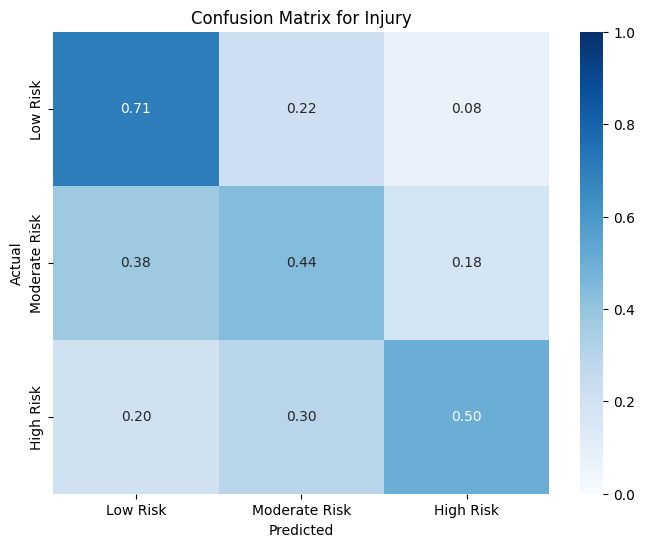

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to 0-1 scale
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the new labels
labels = ['Low Risk', 'Moderate Risk', 'High Risk']

# Plot the confusion matrix with a normalized color bar (0-1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Injury')
#plt.colorbar(label='Proportion')
plt.show()


In [23]:
!pip install shap
import shap

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


In [ ]:
shap.summary_plot(shap_values[:,:,0], X_test,plot_type='bar')